In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from prophet import Prophet
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
#import warnings
#warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

#데이터 로드
#지역별 발전량 데이터
plant_by_region = pd.read_csv('HOME_발전·판매_발전량_지역별.csv', encoding="euc-kr")
plant_by_region.head(5)


/Users/user/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,연도,서울,부산,대구,인천,광주,대전,울산,세종,경기,강원,충북,충남,전북,전남,경북,경남,제주
0,2023,5115143.000,3.749768e+07,2.132742e+06,4.819489e+07,840711.000,303902.000,3.003559e+07,3.913222e+06,8.764708e+07,3.642853e+07,3191549.000,1.059838e+08,1.537567e+07,6.726560e+07,9.465638e+07,4.470857e+07,4755443.000
1,2022,4336753.909,4.657933e+07,2.468916e+06,5.428345e+07,769032.947,295032.691,3.364133e+07,3.278703e+06,8.578016e+07,3.387653e+07,2763199.957,1.078128e+08,1.499092e+07,5.938354e+07,8.984390e+07,4.948159e+07,4815152.918
2,2021,5343889.297,4.035395e+07,2.811757e+06,6.050626e+07,644018.382,182180.361,3.150358e+07,3.776644e+06,8.223265e+07,3.062279e+07,2204815.677,1.112285e+08,1.432243e+07,6.184102e+07,8.138167e+07,4.388539e+07,3967926.374
3,2020,5122176.000,4.064738e+07,2.568644e+06,5.713563e+07,609551.000,167834.000,2.980867e+07,3.552567e+06,7.251266e+07,2.787505e+07,2221149.000,1.141039e+08,1.259953e+07,5.821711e+07,8.586558e+07,3.533287e+07,3821827.000
4,2019,1846891.377,3.752790e+07,2.877896e+06,6.005289e+07,562074.508,167975.238,2.901605e+07,2.463630e+06,7.397688e+07,2.871589e+07,1604430.710,1.239050e+08,1.228227e+07,5.575383e+07,7.982709e+07,4.846502e+07,3994629.140


In [2]:
#전력시장 PPA 설비용량 데이터
ppa_capacity = pd.read_csv('HOME_전력거래_시장참여설비용량(전력시장·PPA)_연료원별.csv', encoding="euc-kr")
ppa_capacity.head(5)

,기간,지역,원자력,석탄,Unnamed: 4,Unnamed: 5,유류,LNG,양수,신재생,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,기타,전력시장 계
0,NaN,NaN,NaN,유연탄,무연탄,계,NaN,NaN,NaN,연료전지,석탄가스화,태양,풍력,수력,해양,바이오,폐기물,계,NaN,NaN
1,2025/03,서울,0.0,0,0,0,0.0,850.428,0.0,86.63,0,18.488000000000003,0,0,0,6.865,32.95,144.933,0.00,995.361
2,2025/03,부산,4550.0,19,0,19,0.0,1895.986,0.0,40.480000000000004,0,147.51999999999992,0.75,0,0,5.069,39.699999999999996,233.51899999999992,0.00,6698.505
3,2025/03,대구,0.0,72.9,0,72.9,0.0,685.000,0.0,3.9,0,113.79099999999998,11.55,4.0600000000000005,0,3,15.600000000000001,151.90099999999998,0.00,909.801
4,2025/03,인천,0.0,5080,0,5080,0.0,8597.147,0.0,265.00000000000006,0,64.17399999999999,49,12.599,0,68.36,33.68,492.81300000000005,7.97,14177.930


In [3]:
#연료원별 발전설비 데이터
plants_by_fuel = pd.read_csv('HOME_발전설비_연료원별.csv', encoding="euc-kr")
plants_by_fuel.head(5) 

,기간,회원구분,급전방식,사업구분,지역,원자력,유연탄,무연탄,유류,LNG,...,신재생,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,기타,합계
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,연료전지,석탄가스화,태양,풍력,수력,해양,바이오,폐기물,NaN,NaN
1,2025/04,합계,합계,합계,서울,0.0,0.0,0.0,0.00,802.346,...,87.22999999999999,0,47.80411500000001,0,0,0,5.8,0,27.95,971.130115
2,2025/04,합계,합계,합계,부산,4550.0,19.0,0.0,0.00,1845.836,...,40.480000000000004,0,275.20129999999995,0.762,0.02,0,4.574,0,33.90,6769.773300
3,2025/04,합계,합계,합계,대구,0.0,72.9,0.0,0.00,640.700,...,4.11,0,390.4740859999999,0,3.56,0,3,0,9.90,1124.644086
4,2025/04,합계,합계,합계,인천,0.0,5080.0,0.0,36.23,8576.747,...,265.1050000000001,0,181.41563499999995,49,12.599,0,76.33,0,30.78,14308.206635


In [4]:
#지역별 전력 사용량 데이터
demand_region = pd.read_csv('연도별 지역별 전력 사용량.csv')
demand_region.head(5)    

,연도,광역지자체,시도코드,가로등,교육용,농사용,산업용,일반용,주택용,심야,기타,총합
0,2012,강원특별자치도,51,172196667,293051224,441005802,7061175741,3799233147,1972682792,0,2165036768,15904382141
1,2012,경기도,41,738842083,1514010541,1997824531,52601767462,23605792093,15730315986,0,4103399706,100291952402
2,2012,경상남도,48,243075999,416176248,1621659109,19564199999,5589506311,4167332028,0,1412997719,33014947413
3,2012,경상북도,47,242890462,559306829,1405384675,32773042358,4735709856,3251912272,0,1542786073,44511032525
4,2012,광주광역시,29,71806470,275833084,71706553,3027236444,2694545416,1802702314,0,186662988,8130493269


In [5]:
#신재생 에너지 발전량 데이터
renew_energy = pd.read_excel('지역별 신재생 에너지 발전량.xlsx')
renew_energy.head(5)

,연도,광역지자체,신재생에너지 합계,재생에너지 합계,신에너지 합계,신재생에너지공급비중,태양광,풍력,수력,해양,바이오,재생폐기물,연료전지,IGCC
0,2023,서울,"755,498","361,266","394,232",1.25,"272,765",184,334,-,"27,069","60,915","394,232",-
1,2023,부산,"738,393","421,541","316,852",1.22,"366,024",63,127,-,"16,435","38,893","316,852",-
2,2023,대구,"560,890","544,440","16,450",0.93,"497,336","16,525","14,033",-,"10,691","5,854","16,450",-
3,2023,인천,"1,966,319","574,288","1,392,031",3.26,"267,782","24,693","13,477",-,"258,055","10,281","1,392,031",-
4,2023,광주,"598,721","418,128","180,593",0.99,"404,724",7,"5,028",-,"2,001","6,367","180,593",-


In [6]:
#데이터 전처리
#신재생 에너지 데이터 전처리 - 쉼표 제거 및 숫자형 변환
numeric_columns = ['신재생에너지합계', '재생에너지 합계', '신에너지 합계', '신재생에너지공급비중', '태양광', '풍력', '수력', '바이오', '재생폐기물', '연료전지']
    
for col in numeric_columns:
    if col in renew_energy.columns:
        renew_energy[col] = renew_energy[col].replace('-', '0')
        renew_energy[col] = renew_energy[col].astype(str).str.replace(',', '').astype(float)
    
#연도별 지역별 데이터 구성
renew_pivot = renew_energy.pivot_table(
    index='연도',
    columns='광역지자체',
    values='신재생에너지 합계',
    aggfunc='sum'
)

renew_pivot   

광역지자체,강원,경기,경남,경북,광주,대구,대전,부산,서울,세종,울산,인천,전남,전북,제주,충남,충북
연도,,,,,,,,,,,,,,,,,
2021,5888937,4733827,2542146,4393519,345741,251812,148871,616236,782277,170224,902327,2020296,6158271,8325469,2662500,8489538,2225401
2022,6479493,5269025,2867620,5315057,471271,293356,224281,693590,723176,169375,689744,1911643,7481402,10385213,2996072,9023827,2785854
2023,"6,510,882","5,672,313","3,381,157","5,804,541","598,721","560,890","225,941","738,393","755,498","171,556","692,284","1,966,319","8,247,703","10,205,081","3,006,387","8,600,653","3,261,546"


In [7]:
#숫자형 컬럼 리스트 (쉼표 제거 및 숫자 변환)
numeric_cols = ['신재생에너지 합계', '재생에너지 합계', '신에너지 합계', '신재생에너지공급비중',
                '태양광', '풍력', '수력', '해양', '바이오', '재생폐기물', '연료전지', 'IGCC']

#쉼표 제거 및 '-'를 NaN으로
for col in numeric_cols:
    renew_energy[col] = renew_energy[col].astype(str).str.replace(',', '')
    renew_energy[col] = renew_energy[col].replace('-', '0')
    renew_energy[col] = pd.to_numeric(renew_energy[col], errors='coerce').fillna(0)

#연도와 광역지자체 분리(if 합쳐져 있다면)
if '연도' not in renew_energy.columns:
    # 예를 들어 '2023 서울' 이렇게 합쳐져 있다면 분리
    renew_energy[['연도', '광역지자체']] = renew_energy['광역지자체'].str.split(' ', expand=True)
    renew_energy['연도'] = pd.to_numeric(renew_energy['연도'])

renew_energy.head()


,연도,광역지자체,신재생에너지 합계,재생에너지 합계,신에너지 합계,신재생에너지공급비중,태양광,풍력,수력,해양,바이오,재생폐기물,연료전지,IGCC
0,2023,서울,755498,361266.0,394232.0,1.25,272765.0,184.0,334.0,0,27069.0,60915.0,394232.0,0
1,2023,부산,738393,421541.0,316852.0,1.22,366024.0,63.0,127.0,0,16435.0,38893.0,316852.0,0
2,2023,대구,560890,544440.0,16450.0,0.93,497336.0,16525.0,14033.0,0,10691.0,5854.0,16450.0,0
3,2023,인천,1966319,574288.0,1392031.0,3.26,267782.0,24693.0,13477.0,0,258055.0,10281.0,1392031.0,0
4,2023,광주,598721,418128.0,180593.0,0.99,404724.0,7.0,5028.0,0,2001.0,6367.0,180593.0,0


In [8]:
renew_energy[numeric_cols].isna().sum()
#renew_energy[numeric_cols] = renew_energy[numeric_cols].fillna(0)
#renew_energy[numeric_cols].isna().sum()

신재생에너지 합계     0
재생에너지 합계      0
신에너지 합계       0
신재생에너지공급비중    0
태양광           0
풍력            0
수력            0
해양            0
바이오           0
재생폐기물         0
연료전지          0
IGCC          0
dtype: int64

In [9]:
#발전량 데이터 재구성
plant_by_region_melted = plant_by_region.melt(id_vars=['연도'], var_name='지역', value_name='발전량')
plant_by_region_melted

,연도,지역,발전량
0,2023,서울,5115143.000
1,2022,서울,4336753.909
2,2021,서울,5343889.297
3,2020,서울,5122176.000
4,2019,서울,1846891.377
...,...,...,...
369,2006,제주,2073808.000
370,2005,제주,1839286.000
371,2004,제주,1649451.000
372,2003,제주,1497661.000


In [10]:
#전력 사용량 데이터 연도별, 지역별 총합 계산
demand_by_region_year = demand_region.groupby(['연도', '광역지자체'])['총합'].sum().reset_index()
demand_by_region_year

region_mapping = {
    '서울특별시': '서울', '부산광역시': '부산', '대구광역시': '대구',
    '인천광역시': '인천', '광주광역시': '광주', '대전광역시': '대전',
    '울산광역시': '울산', '세종특별자치시': '세종',
    '경기도': '경기', '강원특별자치도': '강원',
    '충청북도': '충북', '충청남도': '충남',
    '전라북도': '전북', '전라남도': '전남',
    '경상북도': '경북', '경상남도': '경남',
    '제주특별자치도': '제주'
}

#지역 정규화 함수
def normalize_region(region):
    return region_mapping.get(region.strip(), region.strip())

demand_by_region_year['광역지자체'] =demand_by_region_year['광역지자체'].apply(normalize_region)
demand_by_region_year

,연도,광역지자체,총합
0,2012,강원,15904382141
1,2012,경기,100291952402
2,2012,경남,33014947413
3,2012,경북,44511032525
4,2012,광주,8130493269
...,...,...,...
216,2024,전남,33580743730
217,2024,전북,1971915087
218,2024,제주,6196556305
219,2024,충남,50036919774


In [11]:
#발전원별 탄소배출계수 (kg CO2/MWh) 
emission_factors = {
        '석탄': 820,
        'LNG': 490,
        '유류': 700,
        '원자력': 12,
        '신재생': 34  # 평균적인 계수 (태양광, 풍력 등 포함)
    }
    
#지역별, 연도별 발전원 비중 추정
#전국 평균 발전원 비중을 사용 (2024년 기준 예시)
national_mix = {
        '석탄': 0.294,
        'LNG': 0.298,
        '유류': 0.02,
        '원자력': 0.317,
        '신재생': 0.105
    }

#지역별 발전량 기반 탄소 배출량 계산
plant_by_region_melted = plant_by_region.melt(id_vars=['연도'], var_name='지역', value_name='발전량')
plant_by_region_melted    

,연도,지역,발전량
0,2023,서울,5115143.000
1,2022,서울,4336753.909
2,2021,서울,5343889.297
3,2020,서울,5122176.000
4,2019,서울,1846891.377
...,...,...,...
369,2006,제주,2073808.000
370,2005,제주,1839286.000
371,2004,제주,1649451.000
372,2003,제주,1497661.000


In [12]:
#발전량을 MWh 단위로 변환 (가정: 데이터가 kWh 단위)
plant_by_region_melted['발전량_MWh'] = plant_by_region_melted['발전량'] / 1000
plant_by_region_melted

,연도,지역,발전량,발전량_MWh
0,2023,서울,5115143.000,5115.143000
1,2022,서울,4336753.909,4336.753909
2,2021,서울,5343889.297,5343.889297
3,2020,서울,5122176.000,5122.176000
4,2019,서울,1846891.377,1846.891377
...,...,...,...,...
369,2006,제주,2073808.000,2073.808000
370,2005,제주,1839286.000,1839.286000
371,2004,제주,1649451.000,1649.451000
372,2003,제주,1497661.000,1497.661000


In [13]:
emissions = []

for idx, row in plant_by_region_melted.iterrows():
    year = row['연도']
    region = row['지역']
    generation = row['발전량_MWh']

    # 지역별 신재생 에너지 비중 반영
    region_renewables = 0
    if year in renew_energy['연도'].values and region in renew_energy['광역지자체'].values:
        filtered_renew = renew_energy[
            (renew_energy['연도'] == year) & (renew_energy['광역지자체'] == region)
        ]
        if not filtered_renew.empty:
            region_renewables = filtered_renew['신재생에너지공급비중'].values[0] / 100

    # 나머지 발전원 비중 조정
    remaining = 1 - region_renewables
    adjusted_mix = {
        '석탄': national_mix['석탄'] * remaining,
        'LNG': national_mix['LNG'] * remaining,
        '유류': national_mix['유류'] * remaining,
        '원자력': national_mix['원자력'] * remaining,
        '신재생': region_renewables
    }

    #탄소 배출량 계산 (톤 CO2)
    emission = sum(
        adjusted_mix[fuel] * generation * emission_factors[fuel] / 1000
        for fuel in adjusted_mix
    )

    emissions.append({
        '연도': year,
        '지역': region,
        '발전량_MWh': generation,
        '탄소배출량_톤': emission
    })

emissions_df = pd.DataFrame(emissions)
emissions_df

,연도,지역,발전량_MWh,탄소배출량_톤
0,2023,서울,5115.143000,2047.426524
1,2022,서울,4336.753909,1735.862513
2,2021,서울,5343.889297,2133.238275
3,2020,서울,5122.176000,2073.989551
4,2019,서울,1846.891377,747.813706
...,...,...,...,...
369,2006,제주,2073.808000,839.693154
370,2005,제주,1839.286000,744.734259
371,2004,제주,1649.451000,667.869308
372,2003,제주,1497.661000,606.408930


In [14]:
#Prophet을 이용한 시계열 예측
#전국 탄소 배출량 합계
forecast_years=10
total_emissions = emissions_df.groupby('연도')['탄소배출량_톤'].sum().reset_index()
total_emissions.columns = ['ds', 'y']
total_emissions['ds'] = pd.to_datetime(total_emissions['ds'], format='%Y')
    
#Prophet 모델 학습
model = Prophet(yearly_seasonality=True)
model.fit(total_emissions)
    
#미래 예측
future = model.make_future_dataframe(periods=forecast_years, freq='Y')
forecast = model.predict(future)
    
# 준년도 설정 (2018년 배출량의 순배출 제로 목표)
if len(total_emissions) > 0:
    base_year_emission = total_emissions[total_emissions['ds'].dt.year == 2023]['y'].values
    if len(base_year_emission) > 0:
        base_emission = base_year_emission[0]
    else:
        base_emission = total_emissions['y'].iloc[-1]  # 마지막 데이터 사용
else:
    base_emission = 0
        
    
#탄소중립 목표선 설정 (2050년까지 순배출 제로)
forecast['carbon_neutral_target'] = 0
    
#탄소중립 달성 여부 평가
forecast['carbon_neutral_achieved'] = forecast['yhat'] <= forecast['carbon_neutral_target']
forecast

#ds -> 날짜(datetime)
#yhat -> 예측된 값 (Prophet이 추정한 중앙값, 즉 평균과 유사)
#yhat_lower -> 예측 구간의 하한 (신뢰 구간의 하단, 기본 80% 또는 95%)
#yhat_upper -> 측 구간의 상한 (신뢰 구간의 상단)


12:26:39 - cmdstanpy - INFO - Chain [1] start processing
12:26:39 - cmdstanpy - INFO - Chain [1] done processing
/Users/user/anaconda3/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,carbon_neutral_target,carbon_neutral_achieved
0,2002-01-01,-97126.680734,120156.950336,126043.871772,-97126.680734,-97126.680734,220189.423256,220189.423256,220189.423256,220189.423256,220189.423256,220189.423256,0.0,0.0,0.0,123062.742523,0,False
1,2003-01-01,-88815.324765,129007.865644,134762.296033,-88815.324765,-88815.324765,220680.458526,220680.458526,220680.458526,220680.458526,220680.458526,220680.458526,0.0,0.0,0.0,131865.133762,0,False
2,2004-01-01,-80503.968796,135429.317266,141137.455720,-80503.968796,-80503.968796,218943.907501,218943.907501,218943.907501,218943.907501,218943.907501,218943.907501,0.0,0.0,0.0,138439.938705,0,False
3,2005-01-01,-72169.841992,142425.232154,148205.686148,-72169.841992,-72169.841992,217469.174416,217469.174416,217469.174416,217469.174416,217469.174416,217469.174416,0.0,0.0,0.0,145299.332424,0,False
4,2006-01-01,-63858.486027,153530.673077,159320.621436,-63858.486027,-63858.486027,220189.423256,220189.423256,220189.423256,220189.423256,220189.423256,220189.423256,0.0,0.0,0.0,156330.937229,0,False
5,2007-01-01,-55547.130065,162228.546353,167784.625722,-55547.130065,-55547.130065,220680.458526,220680.458526,220680.458526,220680.458526,220680.458526,220680.458526,0.0,0.0,0.0,165133.328462,0,False
6,2008-01-01,-47235.774102,168803.762463,174736.039924,-47235.774102,-47235.774102,218943.907501,218943.907501,218943.907501,218943.907501,218943.907501,218943.907501,0.0,0.0,0.0,171708.133399,0,False
7,2009-01-01,-38901.647299,175494.638450,181464.687898,-38901.647299,-38901.647299,217469.174416,217469.174416,217469.174416,217469.174416,217469.174416,217469.174416,0.0,0.0,0.0,178567.527117,0,False
8,2010-01-01,-30590.291331,186744.200126,192380.362464,-30590.291331,-30590.291331,220189.423256,220189.423256,220189.423256,220189.423256,220189.423256,220189.423256,0.0,0.0,0.0,189599.131925,0,False
9,2011-01-01,-22279.375846,195584.762139,201427.049121,-22279.375846,-22279.375846,220680.458526,220680.458526,220680.458526,220680.458526,220680.458526,220680.458526,0.0,0.0,0.0,198401.082681,0,False


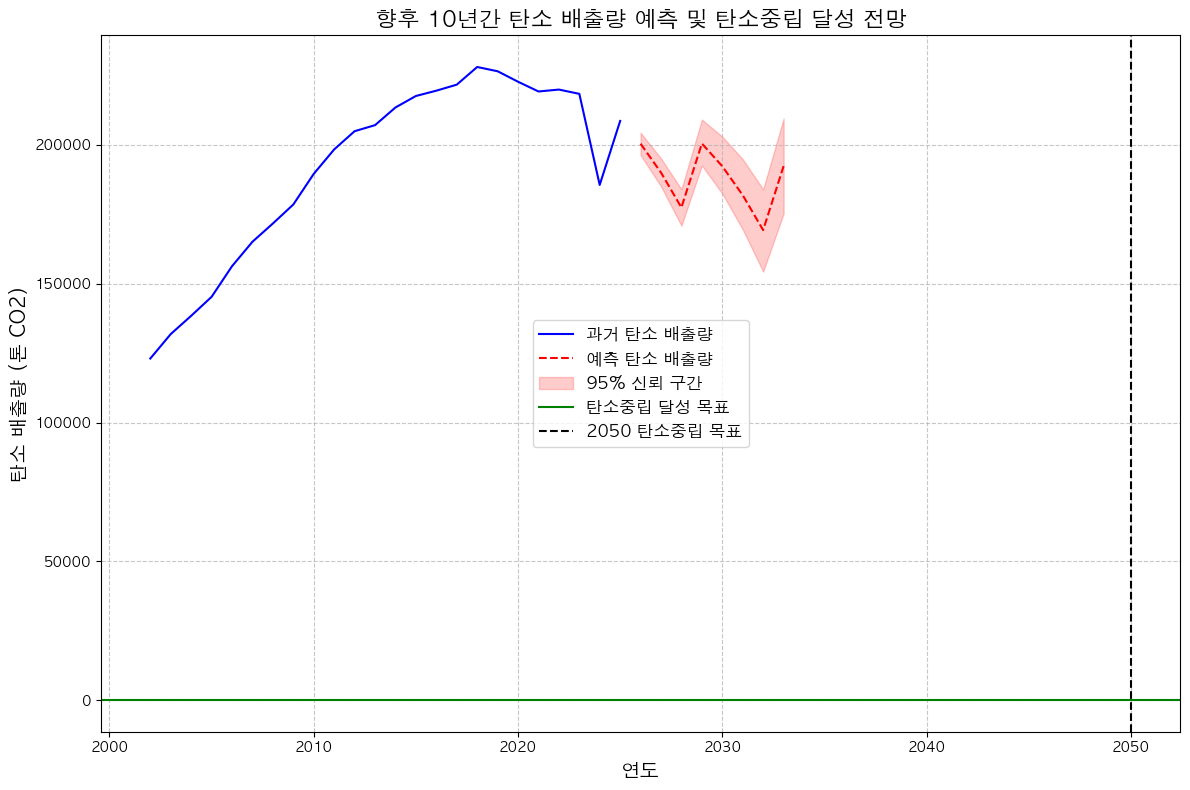

In [36]:
#시각화 
plt.figure(figsize=(12, 8))

#실제 데이터와 예측 데이터
actual_dates = forecast['ds'][forecast['ds'] <= pd.to_datetime('2025-01-01')]
actual_values = forecast['yhat'][forecast['ds'] <= pd.to_datetime('2025-01-01')]

future_dates = forecast['ds'][forecast['ds'] > pd.to_datetime('2025-01-01')]
future_values = forecast['yhat'][forecast['ds'] > pd.to_datetime('2025-01-01')]

#실제 데이터 플롯
plt.plot(actual_dates, actual_values, 'b-', label='과거 탄소 배출량')
#예측 데이터 플롯
plt.plot(future_dates, future_values, 'r--', label='예측 탄소 배출량')

#신뢰 구간
plt.fill_between(future_dates, 
                 forecast['yhat_lower'][forecast['ds'] > pd.to_datetime('2025-01-01')],
                 forecast['yhat_upper'][forecast['ds'] > pd.to_datetime('2025-01-01')],
                 color='r', alpha=0.2, label='95% 신뢰 구간')
#탄소중립 목표선
plt.axhline(y=0, color='g', linestyle='-', label='탄소중립 달성 목표')

#그래프에 2050년 탄소중립 목표 표시
plt.axvline(x=pd.to_datetime('2050-01-01'), color='black', linestyle='--', label='2050 탄소중립 목표')

plt.title('향후 10년간 탄소 배출량 예측 및 탄소중립 달성 전망', fontsize=16)
plt.xlabel('연도', fontsize=14)
plt.ylabel('탄소 배출량 (톤 CO2)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

#탄소중립 달성 여부 판단
#last_forecast = forecast.iloc[-1]
#text = '예측: 2035년까지 탄소중립 달성 가능성 높음' if last_forecast['yhat'] <= 0 else '예측: 2035년까지 탄소중립 달성 어려움'
#color = 'green' if last_forecast['yhat'] <= 0 else 'red'

#plt.text(pd.to_datetime('2030-01-01'), max(forecast['yhat_upper'])*0.8, text, fontsize=14, color=color)
plt.tight_layout()
plt.show()

In [16]:
#지도학습 모델을 통한 지역별 탄소중립 달성 가능성 예측
regions = emissions_df['지역'].unique()
features = []

for region in regions:
    region_emissions = emissions_df[emissions_df['지역'] == region]
    if region_emissions.empty:
        continue
        
    #배출량 추세
    emission_trend = region_emissions.sort_values('연도')
    if len(emission_trend) >= 2:
        emission_change_rate = (
            emission_trend['탄소배출량_톤'].iloc[-1] - emission_trend['탄소배출량_톤'].iloc[0]
        ) / emission_trend['탄소배출량_톤'].iloc[0]
    else:
        emission_change_rate = 0

    #신재생 에너지 비중
    region_renew = renew_energy[renew_energy['광역지자체'] == region]
    avg_renewable_ratio = region_renew['신재생에너지공급비중'].mean() if not region_renew.empty else 0

    #전력 사용량
    region_demand = demand_by_region_year[demand_by_region_year['광역지자체'] == region]
    avg_demand = region_demand['총합'].mean() if not region_demand.empty else 0

    #최근 배출량
    latest_emission = region_emissions.sort_values('연도', ascending=False)['탄소배출량_톤'].iloc[0]

    
    features.append({
        '지역': region,
        '배출량_변화율': emission_change_rate,
        '신재생_비중': avg_renewable_ratio,
        '전력_사용량': avg_demand,
        '최근_배출량': latest_emission
    })

features_df = pd.DataFrame(features)
features_df


/var/folders/xf/ygzwswl16m1djsh0mh20h2l40000gn/T/ipykernel_2455/432055858.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  emission_change_rate = (


,지역,배출량_변화율,신재생_비중,전력_사용량,최근_배출량
0,서울,3.702000,1.346667,4.718474e+10,2047.426524
1,부산,0.392593,1.213333,2.084451e+10,15013.281740
2,대구,16.357036,0.646667,1.543960e+10,856.199071
3,인천,1.068087,3.520000,2.419967e+10,18931.557048
4,광주,inf,0.830000,8.661758e+09,337.320198
5,대전,0.415647,0.350000,9.523170e+09,122.634077
6,울산,1.811766,1.373333,3.190496e+10,12033.416848
7,세종,inf,0.303333,2.999588e+09,1580.415238
8,경기,3.415078,9.283333,1.201536e+11,32436.092285
9,강원,5.654717,11.206667,1.646199e+10,13293.518795


In [17]:
# 결측치 처리
features_df = features_df.fillna(0)

# 학습하기에 데이터가 너무 적으면 그냥 features_df 출력하고 종료
if len(features_df) < 5:
    print("데이터가 너무 적습니다.")
else:
    # 타겟 생성 (배출량 변화율이 -0.05 이하면 탄소중립 가능)
    features_df['탄소중립_가능'] = features_df['배출량_변화율'] <= -0.05

    # 학습데이터와 타겟 분리
    X = features_df[['신재생_비중', '전력_사용량', '최근_배출량']]
    y = features_df['탄소중립_가능']

    if len(X) <= 1:
        print("학습 데이터가 너무 적습니다.")
    else:
        # 스케일링
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # 8:2 분할
        try:
            X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
        except ValueError as e:
            print("데이터 분할 오류:", e)
        else:
            #random forest 학습
            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
            rf_model.fit(X_train, y_train)

            # 예측 및 정확도 계산
            rf_pred = rf_model.predict(X_test)
            rf_accuracy = accuracy_score(y_test, rf_pred)

            # 전체 데이터에 대한 탄소중립 예측
            features_df['RF_탄소중립_예측'] = rf_model.predict(X_scaled)

            print("Random Forest 정확도:", rf_accuracy)


Random Forest 정확도: 0.75


In [18]:
#군집분석용 특성 선택
features = features_df[['신재생_비중', '전력_사용량', '최근_배출량']]

#특성 스케일링
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

#군집 수 결정 (4개 고정)
n_clusters = 4

#데이터가 충분한지 체크
if len(features_scaled) < n_clusters:
    print("데이터가 군집 수보다 적습니다.")
else:
    #K-Means 군집 모델 생성 및 학습
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(features_scaled)

    #결과를 원본 데이터프레임에 추가
    features_df['클러스터'] = clusters

    #결과 출력
    print(features_df[['신재생_비중', '전력_사용량', '최근_배출량', '클러스터']].head())


     신재생_비중        전력_사용량        최근_배출량  클러스터
0  1.346667  4.718474e+10   2047.426524     0
1  1.213333  2.084451e+10  15013.281740     0
2  0.646667  1.543960e+10    856.199071     0
3  3.520000  2.419967e+10  18931.557048     0
4  0.830000  8.661758e+09    337.320198     0



지역별 군집화 결과:
      연도 광역지자체  cluster
2   2021    경남        0
4   2021    광주        0
5   2021    대구        0
6   2021    대전        0
7   2021    부산        0
8   2021    서울        0
9   2021    세종        0
10  2021    울산        0
11  2021    인천        0
14  2021    제주        0
16  2021    충북        0
13  2021    전북        1
15  2021    충남        1
1   2021    경기        2
0   2021    강원        3
3   2021    경북        3
12  2021    전남        3
19  2022    경남        0
21  2022    광주        0
22  2022    대구        0
23  2022    대전        0
24  2022    부산        0
25  2022    서울        0
26  2022    세종        0
27  2022    울산        0
28  2022    인천        0
31  2022    제주        0
33  2022    충북        0
30  2022    전북        1
32  2022    충남        1
18  2022    경기        2
17  2022    강원        3
20  2022    경북        3
29  2022    전남        3
36  2023    경남        0
38  2023    광주        0
39  2023    대구        0
40  2023    대전        0
41  2023    부산        0
42  2023    서울        0
43 

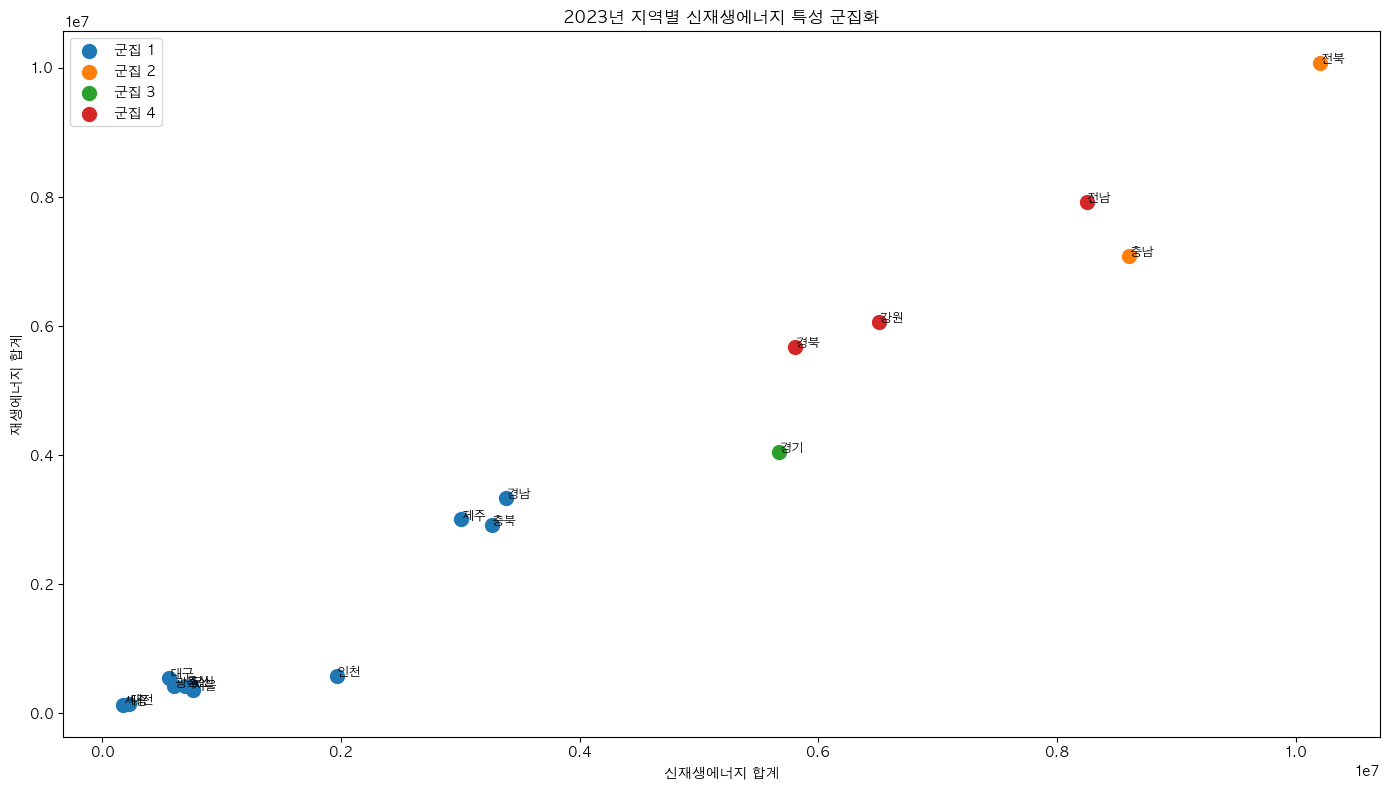

In [19]:
#지역별 군집화 (K-Means)

#연도별, 지역별 평균값 구하기
region_features = renew_energy.groupby(['연도', '광역지자체'], as_index=False)[numeric_cols].mean()

# 표준화
features = region_features[numeric_cols]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# K-Means 군집화 (4개 군집)
kmeans = KMeans(n_clusters=4, random_state=42)
region_features['cluster'] = kmeans.fit_predict(scaled_features)

print("\n지역별 군집화 결과:")
print(region_features[['연도', '광역지자체', 'cluster']].sort_values(['연도', 'cluster']))

# 군집별 시각화 (2023년 데이터만 예시)
plt.figure(figsize=(14, 8))
subset_2023 = region_features[region_features['연도'] == 2023]
for i in range(4):
    cluster_data = subset_2023[subset_2023['cluster'] == i]
    plt.scatter(cluster_data['신재생에너지 합계'], 
                cluster_data['재생에너지 합계'],
                label=f'군집 {i+1}',
                s=100)
    for j, row in cluster_data.iterrows():
        plt.annotate(row['광역지자체'], 
                    (row['신재생에너지 합계'], row['재생에너지 합계']),
                    fontsize=9)

plt.title('2023년 지역별 신재생에너지 특성 군집화')
plt.xlabel('신재생에너지 합계')
plt.ylabel('재생에너지 합계')
plt.legend()
plt.tight_layout()
plt.show()


   광역지자체  cluster
8     서울        0
14    제주        0
11    인천        0
10    울산        0
9     세종        0
7     부산        0
16    충북        0
5     대구        0
4     광주        0
2     경남        0
6     대전        0
3     경북        1
12    전남        1
13    전북        1
0     강원        1
1     경기        2
15    충남        3


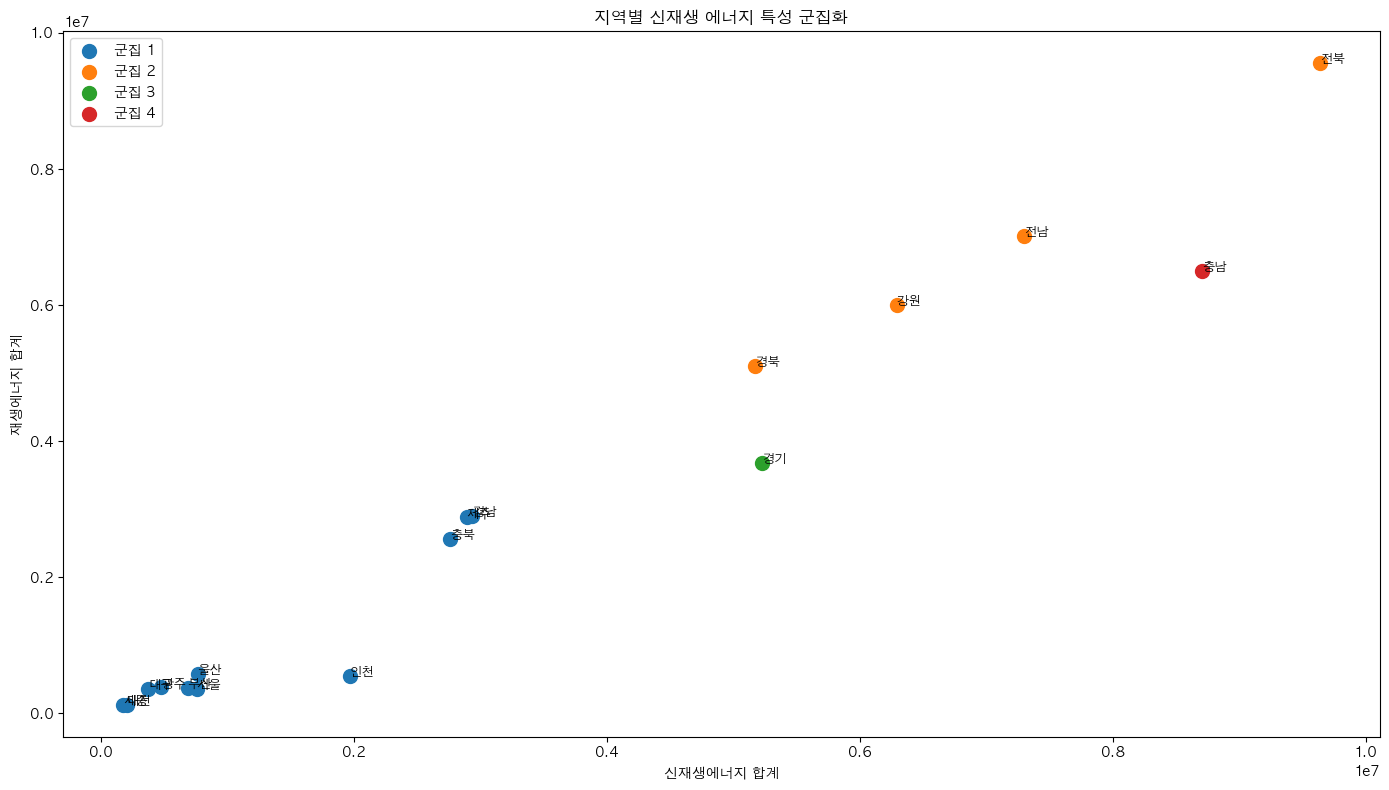

In [20]:
#지역별 신재생 에너지 평균 특성 집계
region_features = renew_energy.groupby('광역지자체').agg({
    '신재생에너지 합계': 'mean',
    '재생에너지 합계': 'mean',
    '신에너지 합계': 'mean',
    '태양광': 'mean',
    '풍력': 'mean',
    '수력': 'mean',
    '해양': 'mean',
    '바이오': 'mean',
    '재생폐기물': 'mean',
    '연료전지': 'mean',
    'IGCC': 'mean'
}).reset_index()

#수치형 변수만 선택(광역지자체 제외)
features = region_features.columns[1:]

# 표준화
scaler = StandardScaler()
scaled_features = scaler.fit_transform(region_features[features])

# KMeans 군집화 (4개 그룹)
kmeans = KMeans(n_clusters=4, random_state=42)
region_features['cluster'] = kmeans.fit_predict(scaled_features)

print(region_features[['광역지자체', 'cluster']].sort_values('cluster'))


#군집별 시각화
plt.figure(figsize=(14, 8))
for i in range(4):
    cluster_data = region_features[region_features['cluster'] == i]
    plt.scatter(cluster_data['신재생에너지 합계'], 
                cluster_data['재생에너지 합계'],
                label=f'군집 {i+1}',
                s=100)
    
    #군집 내 지역 이름 표시
    for j, row in cluster_data.iterrows():
        plt.annotate(row['광역지자체'], 
                    (row['신재생에너지 합계'], row['재생에너지 합계']),
                    fontsize=9)

plt.title('지역별 신재생 에너지 특성 군집화')
plt.xlabel('신재생에너지 합계')
plt.ylabel('재생에너지 합계')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
features_df.groupby('클러스터')[['신재생_비중', '전력_사용량', '최근_배출량']].mean()


,신재생_비중,전력_사용량,최근_배출량
클러스터,,,
0,2.253636,2.048324e+10,6469.301189
1,12.541111,4.190098e+10,32032.146330
2,14.153333,1.844679e+10,9277.699872
3,9.283333,1.201536e+11,32436.092285


In [22]:
#지역별 신재생 에너지 비중과 실제 vs 예측 탄소중립 달성 비교
#inf 값을 NaN으로 바꾸고, NaN을 0 또는 적절한 값으로 대체
features_df['배출량_변화율'].replace([np.inf, -np.inf], np.nan, inplace=True)
features_df['배출량_변화율'].fillna(0, inplace=True)

df_true = features_df[features_df['탄소중립_가능'] == True]
df_false = features_df[features_df['탄소중립_가능'] == False]

df_true_oversampled = pd.concat([df_true]*5, ignore_index=True)
features_df_balanced = pd.concat([df_false, df_true_oversampled], ignore_index=True)
X = features_df_balanced[['신재생_비중', '전력_사용량', '최근_배출량']]
y = features_df_balanced['탄소중립_가능']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

rf_pred = rf_model.predict(X_test)
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00         4
        True       1.00      1.00      1.00         1

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



/var/folders/xf/ygzwswl16m1djsh0mh20h2l40000gn/T/ipykernel_2455/3499725205.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  features_df['배출량_변화율'].replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/xf/ygzwswl16m1djsh0mh20h2l40000gn/T/ipykernel_2455/3499725205.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we ar

In [23]:
#지역별 신재생 에너지 비중과 실제 vs 예측 탄소중립 달성 비교
#탄소중립_가능
features_df

,지역,배출량_변화율,신재생_비중,전력_사용량,최근_배출량,탄소중립_가능,RF_탄소중립_예측,클러스터
0,서울,3.702000,1.346667,4.718474e+10,2047.426524,False,False,0
1,부산,0.392593,1.213333,2.084451e+10,15013.281740,False,False,0
2,대구,16.357036,0.646667,1.543960e+10,856.199071,False,False,0
3,인천,1.068087,3.520000,2.419967e+10,18931.557048,False,False,0
4,광주,0.000000,0.830000,8.661758e+09,337.320198,False,False,0
5,대전,0.415647,0.350000,9.523170e+09,122.634077,False,False,0
6,울산,1.811766,1.373333,3.190496e+10,12033.416848,False,False,0
7,세종,0.000000,0.303333,2.999588e+09,1580.415238,False,False,0
8,경기,3.415078,9.283333,1.201536e+11,32436.092285,False,False,3
9,강원,5.654717,11.206667,1.646199e+10,13293.518795,False,False,2


In [24]:
#지역별 신재생 에너지 비중과 실제 vs 예측 탄소중립 달성 비교
#RF_탄소중립_예측
features_df[features_df['RF_탄소중립_예측'] == True][['지역', '신재생_비중']]
features_df

,지역,배출량_변화율,신재생_비중,전력_사용량,최근_배출량,탄소중립_가능,RF_탄소중립_예측,클러스터
0,서울,3.702000,1.346667,4.718474e+10,2047.426524,False,False,0
1,부산,0.392593,1.213333,2.084451e+10,15013.281740,False,False,0
2,대구,16.357036,0.646667,1.543960e+10,856.199071,False,False,0
3,인천,1.068087,3.520000,2.419967e+10,18931.557048,False,False,0
4,광주,0.000000,0.830000,8.661758e+09,337.320198,False,False,0
5,대전,0.415647,0.350000,9.523170e+09,122.634077,False,False,0
6,울산,1.811766,1.373333,3.190496e+10,12033.416848,False,False,0
7,세종,0.000000,0.303333,2.999588e+09,1580.415238,False,False,0
8,경기,3.415078,9.283333,1.201536e+11,32436.092285,False,False,3
9,강원,5.654717,11.206667,1.646199e+10,13293.518795,False,False,2


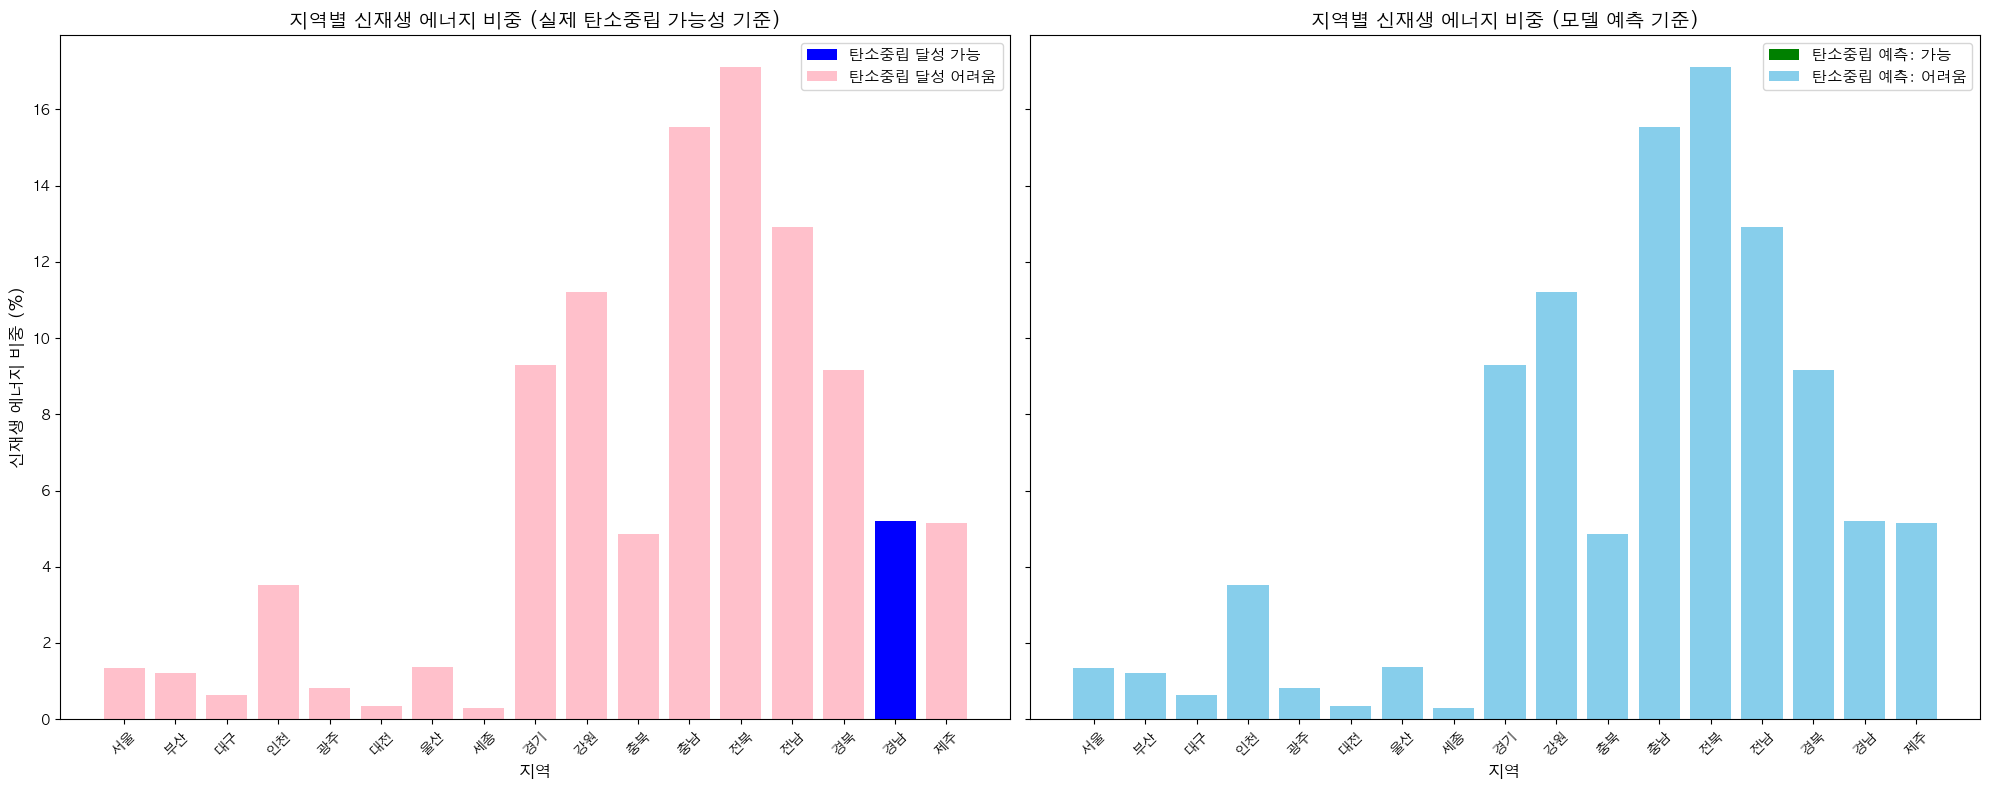

In [25]:
#지역별 신재생 에너지 비중과 실제 vs 예측 탄소중립 달성 비교
regions = features_df['지역']
renewable_ratio = features_df['신재생_비중']

#실제 탄소중립 가능 여부 기준
actual_colors = ['blue' if val else 'pink' for val in features_df['탄소중립_가능']]

#RF 모델 예측 기준
predicted_colors = ['green' if val else 'skyblue' for val in features_df['RF_탄소중립_예측']]

# 그래프 설정
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

#왼쪽: 실제 기준
axes[0].bar(regions, renewable_ratio, color=actual_colors)
axes[0].set_title('지역별 신재생 에너지 비중 (실제 탄소중립 가능성 기준)', fontsize=14)
axes[0].set_xlabel('지역', fontsize=12)
axes[0].set_ylabel('신재생 에너지 비중 (%)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(handles=[
    Patch(facecolor='blue', label='탄소중립 달성 가능'),
    Patch(facecolor='pink', label='탄소중립 달성 어려움')],
    fontsize=11
)

#오른쪽: 예측 기준
axes[1].bar(regions, renewable_ratio, color=predicted_colors)
axes[1].set_title('지역별 신재생 에너지 비중 (모델 예측 기준)', fontsize=14)
axes[1].set_xlabel('지역', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(handles=[
    Patch(facecolor='green', label='탄소중립 예측: 가능'),
    Patch(facecolor='skyblue', label='탄소중립 예측: 어려움')],
    fontsize=11
)


plt.tight_layout()
plt.show()


In [26]:
print(features_df['탄소중립_가능'].value_counts())
print(features_df[features_df['탄소중립_가능'] == True])

탄소중립_가능
False    16
True      1
Name: count, dtype: int64
    지역   배출량_변화율    신재생_비중        전력_사용량        최근_배출량  탄소중립_가능  RF_탄소중립_예측  \
15  경남 -0.145513  5.193333  3.473520e+10  17174.054314     True       False   

    클러스터  
15     0  


/var/folders/xf/ygzwswl16m1djsh0mh20h2l40000gn/T/ipykernel_2455/243541894.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('viridis', len(features_df['클러스터'].unique())),


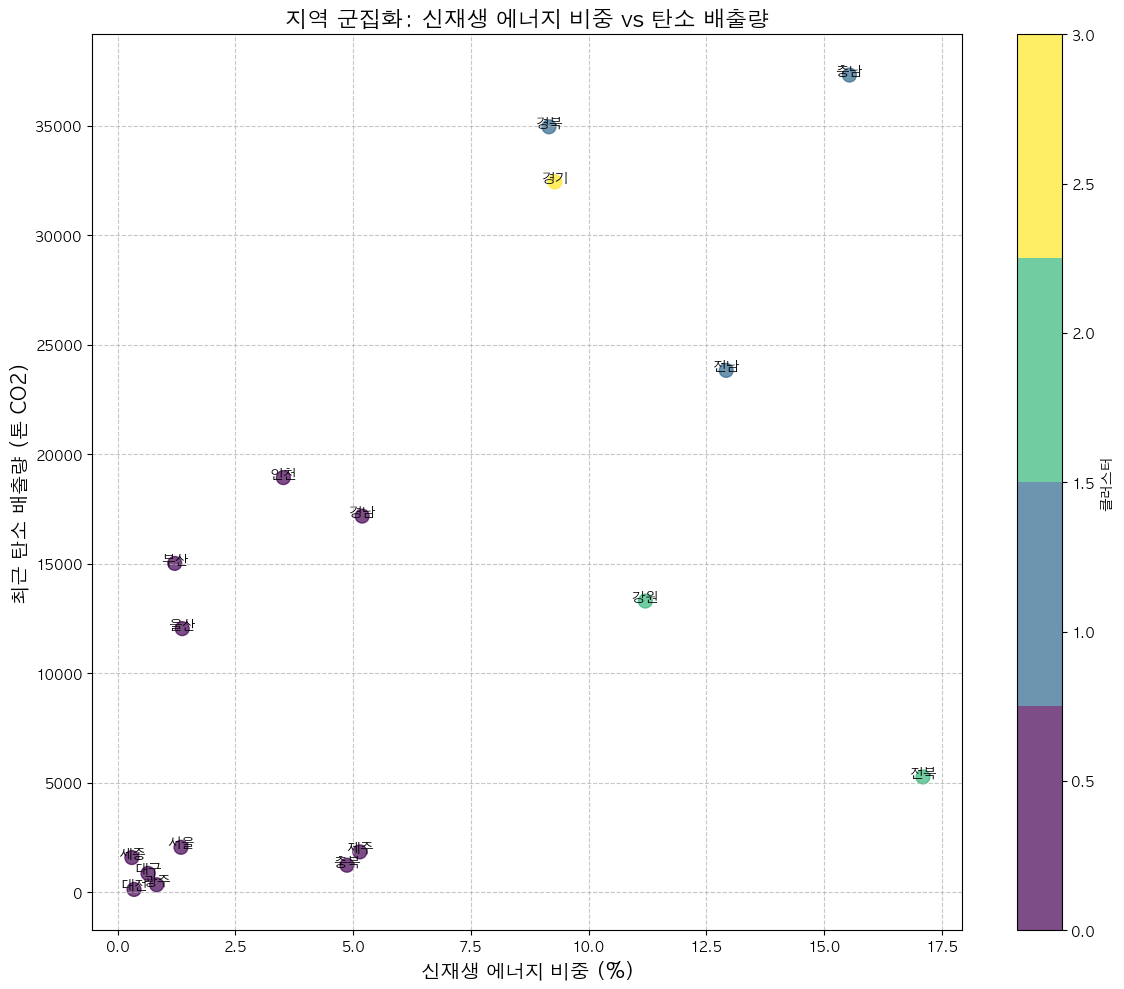

In [27]:
# 조건 검사
if features_df is None or '클러스터' not in features_df.columns or len(features_df) < 2:
    print("군집 분석 결과가 없거나 데이터가 충분하지 않습니다.")
else:
    plt.figure(figsize=(12, 10))
    
    #산점도: 신재생 비중 vs 최근 배출량, 클러스터로 색상
    scatter = plt.scatter(
        features_df['신재생_비중'], 
        features_df['최근_배출량'],
        c=features_df['클러스터'], 
        cmap=plt.cm.get_cmap('viridis', len(features_df['클러스터'].unique())),
        s=100, alpha=0.7
    )
    
    #지역 이름 표시
    for i, txt in enumerate(features_df['지역']):
        plt.annotate(
            txt, 
            (features_df['신재생_비중'].iloc[i], features_df['최근_배출량'].iloc[i]),
            fontsize=10, ha='center'
        )
    
    #컬러바 및 라벨
    plt.colorbar(scatter, label='클러스터')
    plt.title('지역 군집화: 신재생 에너지 비중 vs 탄소 배출량', fontsize=16)
    plt.xlabel('신재생 에너지 비중 (%)', fontsize=14)
    plt.ylabel('최근 탄소 배출량 (톤 CO2)', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()


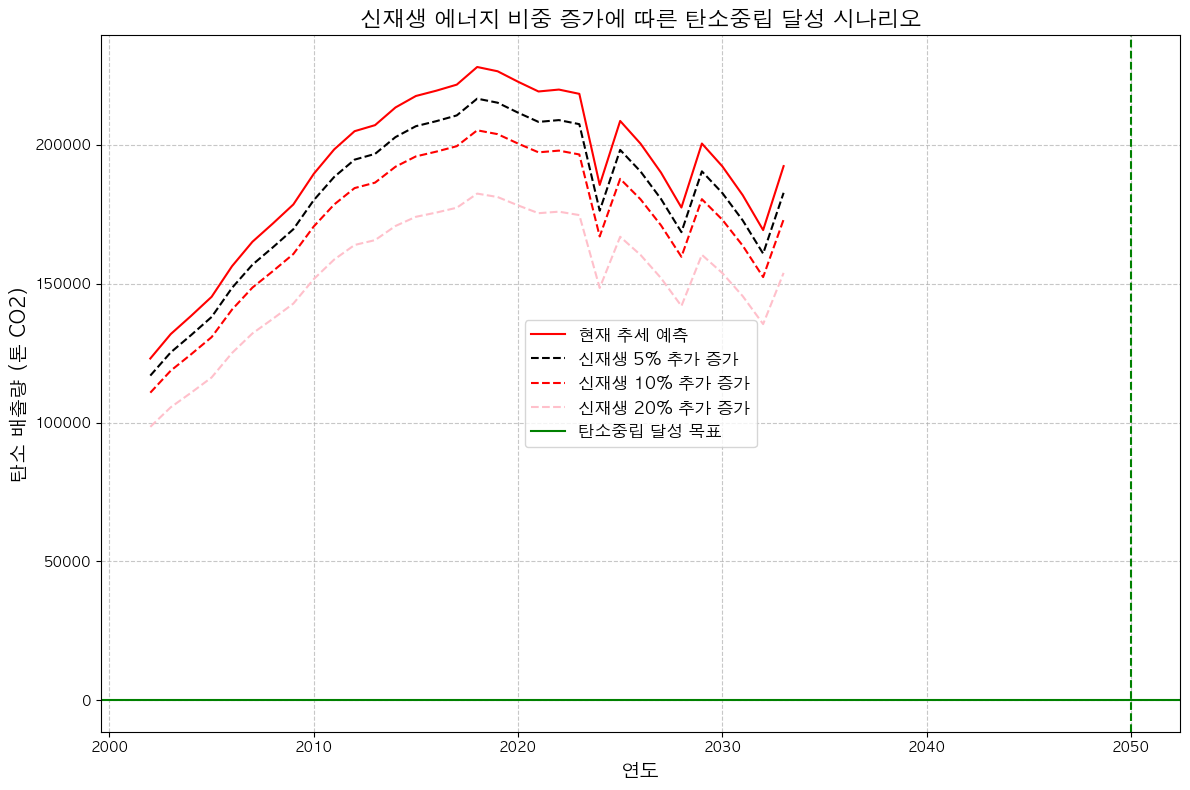

In [28]:
#시뮬레이션 -> forecast와 base_emission이 미리 정의되어 있다고 가정
plt.figure(figsize=(12, 8))

#기본 예측 데이터
plt.plot(forecast['ds'], forecast['yhat'], 'r-', label='현재 추세 예측')

#신재생 에너지 비중 증가 시나리오들
scenarios = {
    '신재생 5% 추가 증가': 0.95,
    '신재생 10% 추가 증가': 0.90,
    '신재생 20% 추가 증가': 0.80
}

colors = ['black', 'red', 'pink']

for i, (name, factor) in enumerate(scenarios.items()):
    adjusted_forecast = forecast.copy()
    adjusted_forecast['yhat'] = forecast['yhat'] * factor
    plt.plot(adjusted_forecast['ds'], adjusted_forecast['yhat'], 
             color=colors[i], linestyle='--', label=name)

#탄소중립 목표선
plt.axhline(y=0, color='g', linestyle='-', label='탄소중립 달성 목표')

plt.title('신재생 에너지 비중 증가에 따른 탄소중립 달성 시나리오', fontsize=16)
plt.xlabel('연도', fontsize=14)
plt.ylabel('탄소 배출량 (톤 CO2)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

#2050년 선 추가
plt.axvline(x=pd.to_datetime('2050-01-01'), color='green', linestyle='--', label='2050 탄소중립 목표')

plt.tight_layout()
plt.show()


In [29]:
#정책 추천 및 결론
if features_df is None or '클러스터' not in features_df.columns:
    result = "충분한 데이터가 없어 정책 추천을 생성할 수 없습니다."
else:
    # 숫자형 컬럼만 선택
    numeric_cols = features_df.select_dtypes(include='number').columns
    cluster_characteristics = features_df.groupby('클러스터')[numeric_cols].mean()
    
    recommendations = []

    for cluster in cluster_characteristics.index:
        cluster_data = cluster_characteristics.loc[cluster]
        regions = features_df[features_df['클러스터'] == cluster]['지역'].tolist()

        if cluster_data['신재생_비중'] < 5:
            recommendation = f"클러스터 {cluster} (지역: {', '.join(regions)}): 신재생 에너지 비중이 매우 낮음. 태양광, 풍력 발전 인프라 확충 우선 추진 필요."
        elif cluster_data['신재생_비중'] < 10:
            recommendation = f"클러스터 {cluster} (지역: {', '.join(regions)}): 신재생 에너지 비중 확대를 위한 인센티브 제도 강화, 산업용 태양광 확대."
        else:
            recommendation = f"클러스터 {cluster} (지역: {', '.join(regions)}): 신재생 에너지 선도 지역. 에너지 저장 시스템(ESS) 확충 및 분산형 전원 구축 강화."

        if cluster_data['최근_배출량'] > 5000000:
            recommendation += " 대규모 산업시설 탄소 포집 기술(CCUS) 도입 시급."
        elif cluster_data['최근_배출량'] > 1000000:
            recommendation += " 산업부문 에너지 효율화 및 전기화 지원 확대."

        recommendations.append(recommendation)

    last_forecast = forecast.iloc[-1]

    if last_forecast['yhat'] <= 0:
        national_recommendation = "전국 단위 분석: 현 추세 유지 시 2035년까지 탄소중립 달성 가능성 있음. 신재생 에너지 전환 정책 강화 및 탄소배출권 거래제 확대 필요."
    else:
        national_recommendation = "전국 단위 분석: 현 추세로는 2035년까지 탄소중립 달성 어려움. 탄소세 도입, 석탄발전 단계적 폐지, 수소경제 전환 등 과감한 정책 필요."

    recommendations.append(national_recommendation)
    result = "\n\n".join(recommendations)
    print(result)


클러스터 0 (지역: 서울, 부산, 대구, 인천, 광주, 대전, 울산, 세종, 충북, 경남, 제주): 신재생 에너지 비중이 매우 낮음. 태양광, 풍력 발전 인프라 확충 우선 추진 필요.

클러스터 1 (지역: 충남, 전남, 경북): 신재생 에너지 선도 지역. 에너지 저장 시스템(ESS) 확충 및 분산형 전원 구축 강화.

클러스터 2 (지역: 강원, 전북): 신재생 에너지 선도 지역. 에너지 저장 시스템(ESS) 확충 및 분산형 전원 구축 강화.

클러스터 3 (지역: 경기): 신재생 에너지 비중 확대를 위한 인센티브 제도 강화, 산업용 태양광 확대.

전국 단위 분석: 현 추세로는 2035년까지 탄소중립 달성 어려움. 탄소세 도입, 석탄발전 단계적 폐지, 수소경제 전환 등 과감한 정책 필요.


In [30]:
#결과 요약
last_forecast = forecast.iloc[-1]
neutrality_probability = "높음" if last_forecast['yhat'] <= 0 else "낮음"

print(f"\n  탄소중립 달성 가능성 분석 결과 ")
print(f"향후 10년 내 탄소중립 달성 가능성: {neutrality_probability}")
print(f"2035년 예상 탄소 배출량: {last_forecast['yhat']:.2f} 톤 CO2")

#가장 효과적인 정책 방향 지역
if features_df is not None and 'RF_탄소중립_예측' in features_df.columns:
    most_effective_regions = features_df[features_df['RF_탄소중립_예측'] == True]['지역'].tolist()
else:
    most_effective_regions = []

print(f"탄소중립 달성 가능성이 높은 지역: {', '.join(most_effective_regions) if most_effective_regions else '없음'}")



  탄소중립 달성 가능성 분석 결과 
향후 10년 내 탄소중립 달성 가능성: 낮음
2035년 예상 탄소 배출량: 192390.20 톤 CO2
탄소중립 달성 가능성이 높은 지역: 없음
